# EDA & Hypotheis testing

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as stats

Set seaborn style and register progress bar

In [3]:
# set up the environment
sns.set(style="darkgrid")
ProgressBar().register()

Define constants such as SEED, SAMPLE_RATE, and FILE_PATHS for data files

In [4]:
# Constants
SEED = 1
SAMPLE_RATE = 0.1
FILE_PATHS = [
    f"data/JC-2022{i:02d}-citibike-tripdata.csv" for i in range(1, 12)
] + ["data/JC-202112-citibike-tripdata.csv"]

Define functions for preprocessing and loading data

In [5]:
# Function definitions
def preprocess_data(data):
    data = data.copy()
    data["started_at"] = dd.to_datetime(data["started_at"])
    data["ended_at"] = dd.to_datetime(data["ended_at"])
    
    data["started_at_year"] = data["started_at"].dt.year
    data["started_at_month"] = data["started_at"].dt.month
    data["started_at_day"] = data["started_at"].dt.day
    data["started_at_hour"] = data["started_at"].dt.hour
    data["started_at_minutes"] = data["started_at"].dt.minute
    data["started_at_seconds"] = data["started_at"].dt.second
    data["date_of_week"] = data["started_at"].dt.weekday
    
    return data

def load_and_preprocess_data(file_paths, sample_rate):
    data_arr = [
        dd.read_csv(file_path).sample(frac=sample_rate, random_state=SEED)
        for file_path in file_paths
    ]
    data = dd.concat(data_arr)
    data = preprocess_data(data)
    
    return data


Load and preprocess data

In [6]:
data = load_and_preprocess_data(FILE_PATHS, SAMPLE_RATE)
data_length = data.count().compute()

#print(data_length)
#data.head()

[########################################] | 100% Completed |  3.3s


Split data into weekday_data and weekend_data

In [7]:
weekday_data = data[data["date_of_week"] < 5].persist()
weekend_data = data[data["date_of_week"] >= 5].persist()

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.2s


Save weekday_data and weekend_data to separate CSV files, to reduce memory need.

In [8]:
weekday_data.to_csv("weekday_data.csv", index=False)
weekend_data.to_csv("weekend_data.csv", index=False)

weekday_data.head()

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.1s


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,started_at_year,started_at_month,started_at_day,started_at_hour,started_at_minutes,started_at_seconds,date_of_week
4686,6004D49CBE416136,classic_bike,2022-01-19 22:36:16,2022-01-19 22:45:15,Hoboken Terminal - River St & Hudson Pl,HB102,Bloomfield St & 15 St,HB203,40.736068,-74.029127,40.754530,-74.026580,member,2022,1,19,22,36,16,2
25684,B2E87D0BFC6AB6EF,electric_bike,2022-01-06 19:35:07,2022-01-06 19:36:56,Newark Ave,JC032,Van Vorst Park,JC035,40.721525,-74.046305,40.718489,-74.047727,member,2022,1,6,19,35,7,3
26492,9AD592C69BE442F2,classic_bike,2022-01-27 08:07:03,2022-01-27 08:16:09,Hamilton Park,JC009,Marin Light Rail,JC013,40.727596,-74.044247,40.714584,-74.042817,member,2022,1,27,8,7,3,3
14435,E0C4E934257F380E,classic_bike,2022-01-25 07:28:03,2022-01-25 07:31:33,Monmouth and 6th,JC075,Grove St PATH,JC005,40.725685,-74.048790,40.719586,-74.043117,member,2022,1,25,7,28,3,1
26148,706261E9FF9C4A95,classic_bike,2022-01-17 14:57:13,2022-01-17 15:12:29,Madison St & 10 St,HB503,Willow Ave & 12 St,HB505,40.749943,-74.035865,40.751867,-74.030377,member,2022,1,17,14,57,13,0


Calculate value counts for weekday_data and weekend_data, needed for later

In [9]:
weekday_counts = weekday_data["date_of_week"].value_counts().compute()
weekend_counts = weekend_data["date_of_week"].value_counts().compute()
print("Weekday counts:", weekday_counts)
print("Weekend counts:", weekend_counts)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
Weekday counts: 2    13407
4    13341
3    12967
1    12579
0    11600
Name: date_of_week, dtype: int64
Weekend counts: 5    13472
6    12126
Name: date_of_week, dtype: int64


Print and visualize the number of rides for each weekday
This plot helps us to understand the distribution of rides during the weekdays

In [10]:
print("Number of Rides for Each Weekday")
for i,val in enumerate(weekday_counts.index):
    print(val,  ": " , weekday_counts.values[i])
    
print("col 1: Day of Week")
print("cold 2: Number of Rides")

Number of Rides for Each Weekday
2 :  13407
4 :  13341
3 :  12967
1 :  12579
0 :  11600
col 1: Day of Week
cold 2: Number of Rides


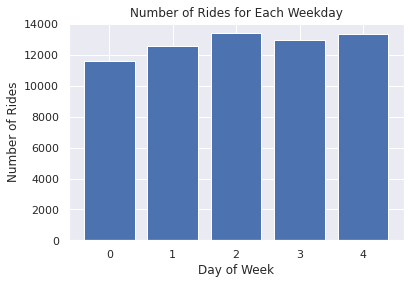

In [11]:
plt.bar(weekday_counts.index, weekday_counts.values)
plt.xlabel("Day of Week")
plt.ylabel("Number of Rides")
plt.title("Number of Rides for Each Weekday")
plt.show()

In [12]:
print("Number of Rides for Each Weekend day")
for i,val in enumerate(weekend_counts.index):
    print(val,  ": " , weekend_counts.values[i])
    
print("col 1: Day of Week")
print("cold 2: Number of Rides")

Number of Rides for Each Weekend day
5 :  13472
6 :  12126
col 1: Day of Week
cold 2: Number of Rides


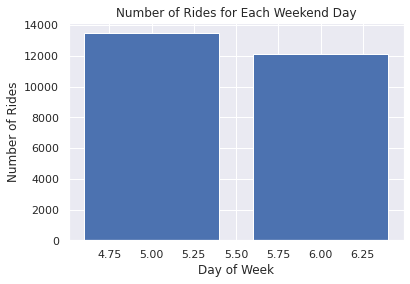

In [13]:
plt.bar(weekend_counts.index, weekend_counts.values)
plt.xlabel("Day of Week")
plt.ylabel("Number of Rides")
plt.title("Number of Rides for Each Weekend Day")
plt.show()


The high p-value indicates that there is no significant difference between the number of rides on weekdays and weekends

In [14]:
p_value = stats.ttest_ind(weekday_counts, weekend_counts)
print("T-test p-value (weekday_counts, weekend_counts) :", p_value)

T-test p-value (weekday_counts, weekend_counts) : Ttest_indResult(statistic=-0.030754475391772108, pvalue=0.9766552067089159)


filter the data into two separate DataFrames: one for members and one for casual users. Also, we count the number of rides per day for both member and casual users.

In [15]:
members_data = data[data["member_casual"] == "member"].persist()
casuals_data = data[data["member_casual"] == "casual"].persist()


member_counts = members_data["started_at_day"].value_counts().compute()
casual_counts = casuals_data["started_at_day"].value_counts().compute()

print("Member counts:", member_counts)
print("Casual counts:", casual_counts)

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
Member counts: 14    2167
15    2112
8     2080
10    2048
21    2023
12    2011
17    1986
28    1984
26    1976
18    1961
9     1957
16    1952
23    1942
29    1934
13    1923
11    1916
19    1888
22    1877
1     1863
2     1863
5     1846
25    1844
20    1822
7     1809
3     1805
24    1770
30    1762
27    1746
6     1734
4     1722
31    1122
Name: started_at_day, dtype: int64
Casual counts: 15    1181
17    1172
10    1149
12    1127
30    1124
9     1102
4     1095
5     1093
26    1079
16    1048
18    1042
11    1023
19    1018
23    1013
21    1013
24    1009
20    1006
14    1006
13     991
22     989
2      976
8      975
29     975
25     947
6      929
27     906
3      905
28     893
1      886
7  

In [16]:
print("Number of Rides for Members")
for i,val in enumerate(member_counts.index):
    print(val,  ": " , member_counts.values[i])
    
print("col 1: Day of Month")
print("cold 2: Number of Rides")

Number of Rides for Members
14 :  2167
15 :  2112
8 :  2080
10 :  2048
21 :  2023
12 :  2011
17 :  1986
28 :  1984
26 :  1976
18 :  1961
9 :  1957
16 :  1952
23 :  1942
29 :  1934
13 :  1923
11 :  1916
19 :  1888
22 :  1877
1 :  1863
2 :  1863
5 :  1846
25 :  1844
20 :  1822
7 :  1809
3 :  1805
24 :  1770
30 :  1762
27 :  1746
6 :  1734
4 :  1722
31 :  1122
col 1: Day of Month
cold 2: Number of Rides


The plot is useful to visualize the distribution of rides throughout the month for members.

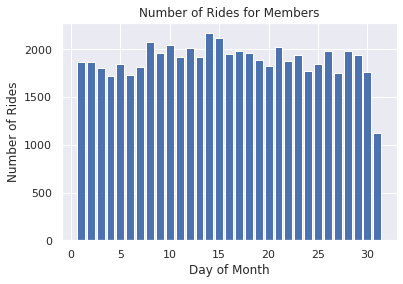

In [17]:
plt.bar(member_counts.index, member_counts.values)
plt.xlabel("Day of Month")
plt.ylabel("Number of Rides")
plt.title("Number of Rides for Members")
plt.show()

In [18]:
print("Number of Rides for Casual Users")
for i,val in enumerate(casual_counts.index):
    print(val,  ": " , casual_counts.values)
    
print("col 1: Day of Month")
print("cold 2: Number of Rides")

Number of Rides for Casual Users
15 :  [1181 1172 1149 1127 1124 1102 1095 1093 1079 1048 1042 1023 1018 1013
 1013 1009 1006 1006  991  989  976  975  975  947  929  906  905  893
  886  785  590]
17 :  [1181 1172 1149 1127 1124 1102 1095 1093 1079 1048 1042 1023 1018 1013
 1013 1009 1006 1006  991  989  976  975  975  947  929  906  905  893
  886  785  590]
10 :  [1181 1172 1149 1127 1124 1102 1095 1093 1079 1048 1042 1023 1018 1013
 1013 1009 1006 1006  991  989  976  975  975  947  929  906  905  893
  886  785  590]
12 :  [1181 1172 1149 1127 1124 1102 1095 1093 1079 1048 1042 1023 1018 1013
 1013 1009 1006 1006  991  989  976  975  975  947  929  906  905  893
  886  785  590]
30 :  [1181 1172 1149 1127 1124 1102 1095 1093 1079 1048 1042 1023 1018 1013
 1013 1009 1006 1006  991  989  976  975  975  947  929  906  905  893
  886  785  590]
9 :  [1181 1172 1149 1127 1124 1102 1095 1093 1079 1048 1042 1023 1018 1013
 1013 1009 1006 1006  991  989  976  975  975  947  929  906  905 

This cell creates a bar chart showing the number of rides for casual users per day. The plot is useful to visualize the distribution of rides throughout the month for casual users.

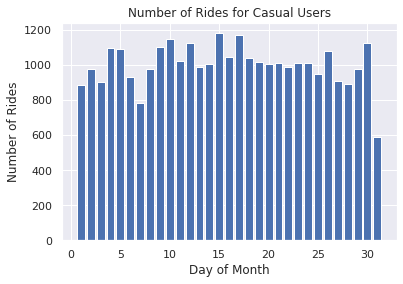

In [19]:
plt.bar(casual_counts.index, casual_counts.values)
plt.xlabel("Day of Month")
plt.ylabel("Number of Rides")
plt.title("Number of Rides for Casual Users")
plt.show()

no significant difference between the two group means

In [15]:
p_value_members_casuals = stats.ttest_ind(member_counts, casual_counts)
print("T-test p-value for members vs casuals:", p_value_members_casuals)

T-test p-value for members vs casuals: Ttest_indResult(statistic=22.74512917377711, pvalue=3.4327461217737515e-31)
